# 3.2.2 How do the subject expectations about the quality of feedback influence training ?

A few simulations to study how subject expectations of the feedback and its true noise interact to influence the training.

In this simulation, the subject does not change its initial observation mapping and doesn't compute its associated novelty term when planning its new action.


In [8]:
# Make basic package imports
import numpy as np
import statistics as stat
import scipy.stats as scistats
import math,sys,os
import pickle 
import matplotlib.pyplot as plt

# Import actynf and the functions to help us plot the results
import actynf
from tools import simulate_and_save,extract_training_data,save_object_to # Saving and loading simulation outputs
from tools import dist_kl_dir # A tool to qualify subject learning
from tools import clever_running_mean,color_spectrum # Plotting helpers

from tools_trial_plots import plot_one_trial,plot_training_curve


from m1_model import neurofeedback_training # The Active Inference model we use

SAVING_FOLDER = os.path.join("..","..","simulation_outputs","paper1","3.2.2")
FIGURES_FOLDER = os.path.join("figures","3.2.2")
print("Results will be saved to " + SAVING_FOLDER + " (relative to this file)")

# Functions defining the model and plotting the results !
def run_and_save_model(savepath,
        true_feedback_std,belief_feedback_std,
        Nsubj,Ntrials,
        overwrite=False):
    """
    Run a simulation of model m1 using the following parameters : 
    - savepath : where to store simulation outputs
    - true_feedback_std : wanted sigma_process value
    - belief_feedback_std : wanted sigma_model value for the feedback
    - Nsubj : subjects simulated for the simulations
    - Ntrials : how many trials simulated per subject (duration of the training)
    - overwrite : run simulations even if there exist results already ?
    """
    learn_a = False # In this first simulation, the subjects won't be questionning their feedback mappings

    T = 10
    Th = 2
    feedback_resolution = 5 # No

    subj_cognitive_resolution = 5 # Ns (model)
    true_cognitive_resolution = 5 # Ns (process)

    k1b = 1.0   # Initial action mapping weight
    epsilon_b = 1.0

    k1a = 10     # Initial feedback mapping weight (model)
    epsilon_a = 0.0/101.0   # Added uniform distribution weight added
        # a0 is defined as = norm(epsilon_a* ones + gaussian_prior)*k1a

    k1d = 1.0   # Initial starting state mapping weight (model)
    epsilon_d = 1.0  # Added uniform distribution weight added
        # d0 is defined as = norm(epsilon_d* ones + [1,1,0,0,0])*k1d   [for Ns=5]
    
    neutral_action_prop = 0.2 # 20% of the actions have no effect on the subject cognitive state

    pRest = 0.5   # Without any increasing action, there is a pRest chance that the cognitive state will decrease spontaneously
    pEffect  = 0.99   # An adequate action will increase the subject mental state with a probability pEffect

    action_selection_inverse_temp = 32.0 # How much noise in the selection of actions after EFE calculation
    
    net = neurofeedback_training(T,Th,  # Trial duration + temporal horizon
            subj_cognitive_resolution,true_cognitive_resolution,       # Subject belief about cognitive resolution / true cognitive resolution
            feedback_resolution,feedback_resolution,       # Subject belief about feedback resolution / true feedback resolution
            belief_feedback_std,true_feedback_std,   # Subject belief about feedback noise / true feedback noise
            neutral_action_prop,       # how many actions have no impact on the state ?
            k1b,epsilon_b,  # Action mapping previous knowledge
            k1a,epsilon_a,   # Feedback mapping previous knowledge
            k1d,epsilon_d,   # d mapping previous knowledge
            pRest,pEffect,   # How likely it is that the cognitive state will go down when unattended
                        # / how likely it is that the correct action will increase the cognitive state
            clamp_gaussian=False,asit = action_selection_inverse_temp,
            learn_a=learn_a) 
                        # Clamp : Weither to increase the categorical probabilistic weights
                        # on the edges or not
                        # asit : inverse temperature of the action selection process
                        # learn_a : Weither to learn the perception matrix on the go                                       

    fig,axes = plt.subplots(1,2)
    axes[0].imshow(actynf.normalize(net.layers[0].a[0]),vmin=0.0,vmax=1.0)
    axes[0].set_title("TRUE feedback")
    axes[1].imshow(actynf.normalize(net.layers[1].a[0]),vmin=0.0,vmax=1.0)
    axes[1].set_title("SUBJECT feedback model")
    for ax in axes : 
        ax.set_ylabel("Feedback level")
        ax.set_ylabel("Cognitive level")
    fig.suptitle("Starting parameters for this simulation")
    fig.show()
    
    simulate_and_save(net,savepath,Nsubj,Ntrials,override=overwrite)

    return net

Results will be saved to ..\..\simulation_outputs\paper1\3.2.2 (relative to this file)


We use the m1_model as a basis for our simulations here. The m1_model has plenty of parameters but only some of them will be of interest to us to answer question 3.2.2.


## 1. Simulation 1

**Simulation 1 :** Let's run the model for a perfect feedback ($\sigma_{process} = 0.01$) but a circonspect subject ($\sigma_{model} = 0.5$) :

C:\Users\annic\AppData\Local\Temp\ipykernel_34428\322674215.py:91: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


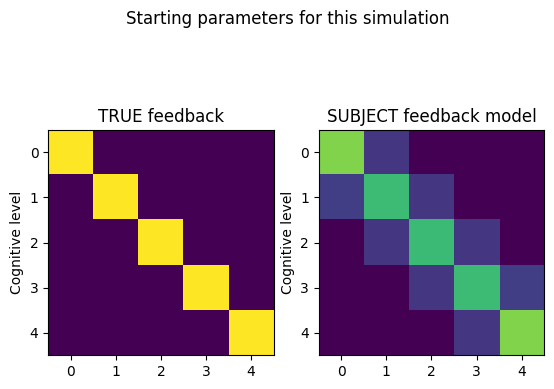

In [9]:
savepath = os.path.join(SAVING_FOLDER,"simulation1")

sigma_process = 0.01
sigma_model = 0.5

N_subj = 10
N_trials = 150

run_and_save_model(savepath,sigma_process,sigma_model,N_subj,N_trials)

We can then use the saved results to plot the training procedure :

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


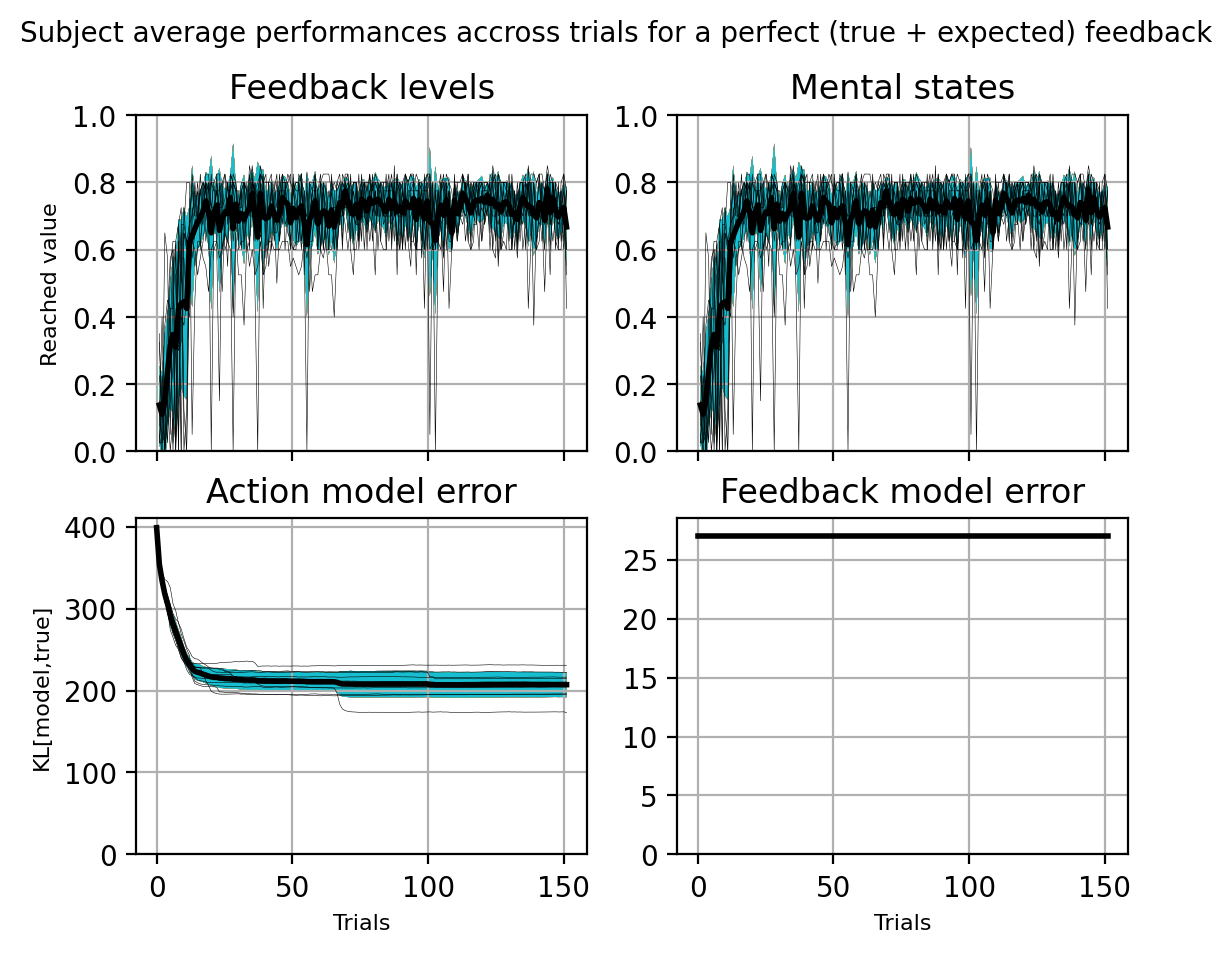

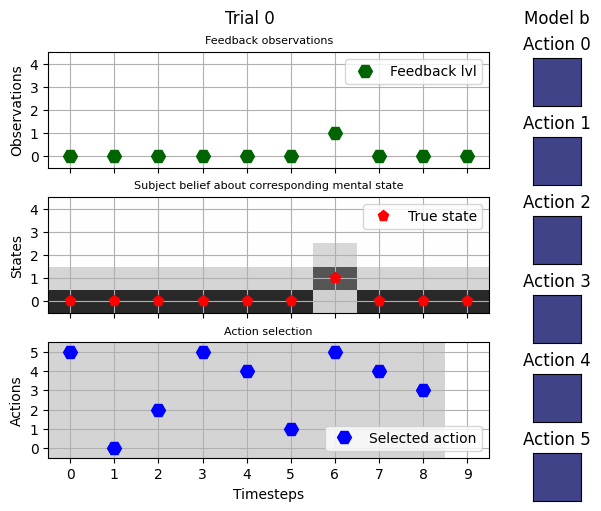

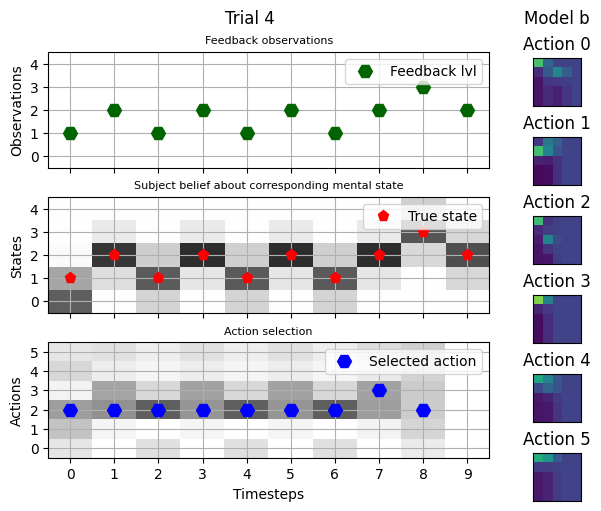

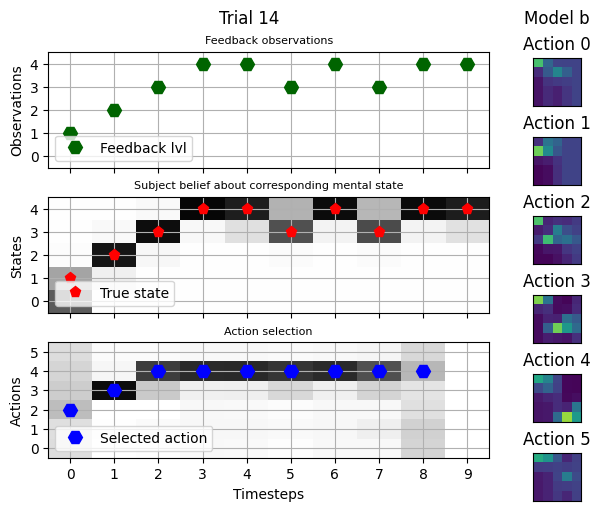

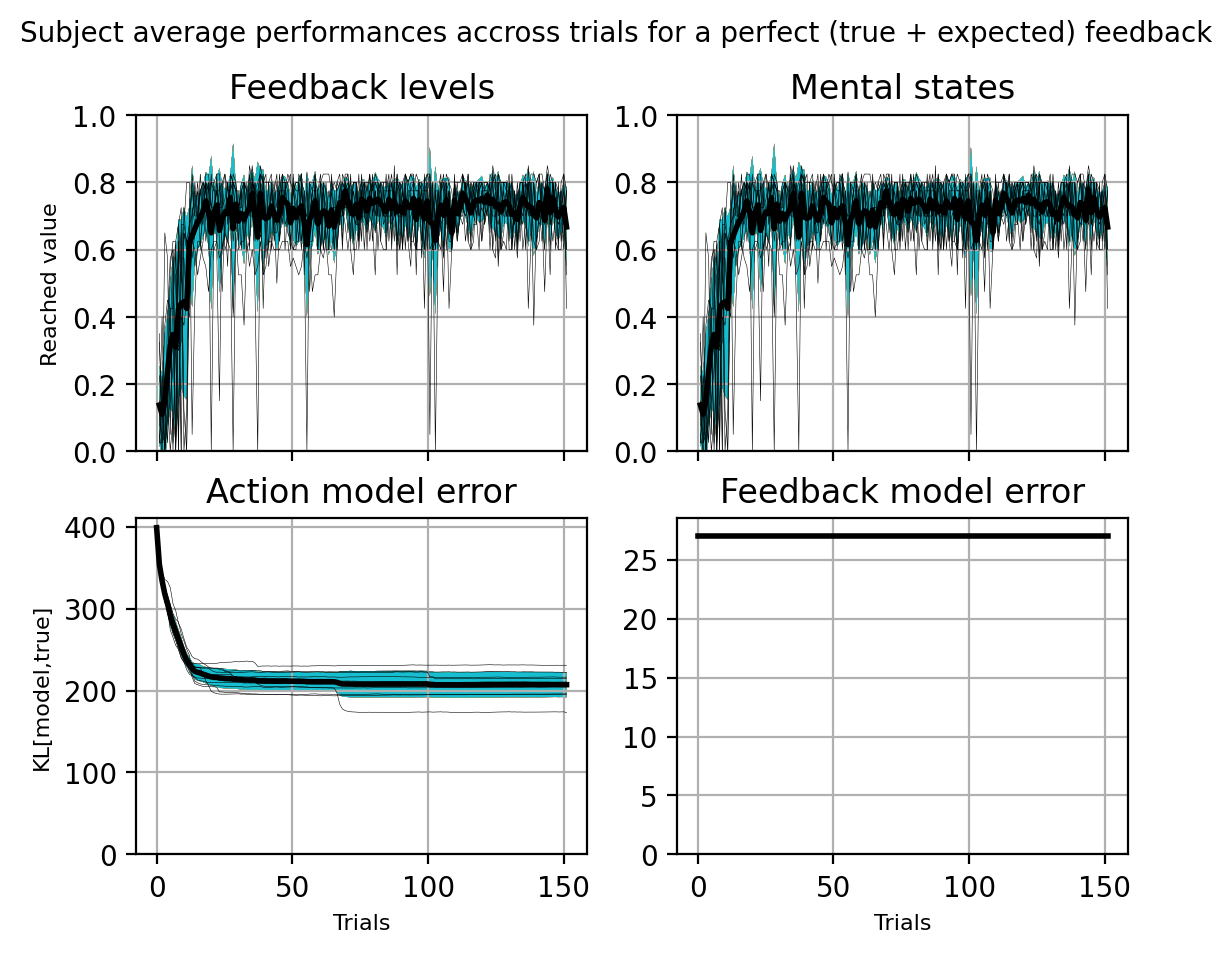

In [10]:
saved_data_path = os.path.join(SAVING_FOLDER,"simulation1")
_stm,_weight,_Nsubj,_Ntrials = extract_training_data(saved_data_path)
# stm : short term memories : the hidden states, observation, action and subject inferences for a specific trial 
# (starting from 1 to Ntrials)
# weights : the weights of the subject models for a given trial
# (starting from 0[before training] to Ntrials)

subject = 4 # What subject are we studying ?
plot_these_trials = [0,4,14]
for trial in (plot_these_trials):
    plot_one_trial(_stm,_weight,subject,trial,"Trial " + str(trial),
                   save_fig_path=os.path.join(FIGURES_FOLDER,"sim1"),
                   name="trial_"+str(trial)+".png")   
plot_training_curve(_stm,_weight,"Subject average performances accross trials for a perfect (true + expected) feedback",
                save_fig_path=os.path.join(FIGURES_FOLDER,"sim1"),
                name="training_curve.png")


The subject expectations over the feedback quality had a significant impact on the training : the quality of the action model eventually reached by the subject wasn't as good as the one obtained when the subject thought the feedback was perfect. 

However, despite the fact that the subjects were quite doubtful of the feedback, we can see that they still managed to self-regulate successfully : it appears that being quite circonspect of a good feedback may not render the training useless.

## Simulation 2 : 

Let's crank the subject doubts about the feedback up ! We set $\sigma_{model} = 1.5$ for this simulation, in effect modeling a feedback believing the feedback to be extremely noisy. 

C:\Users\annic\AppData\Local\Temp\ipykernel_34428\322674215.py:91: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


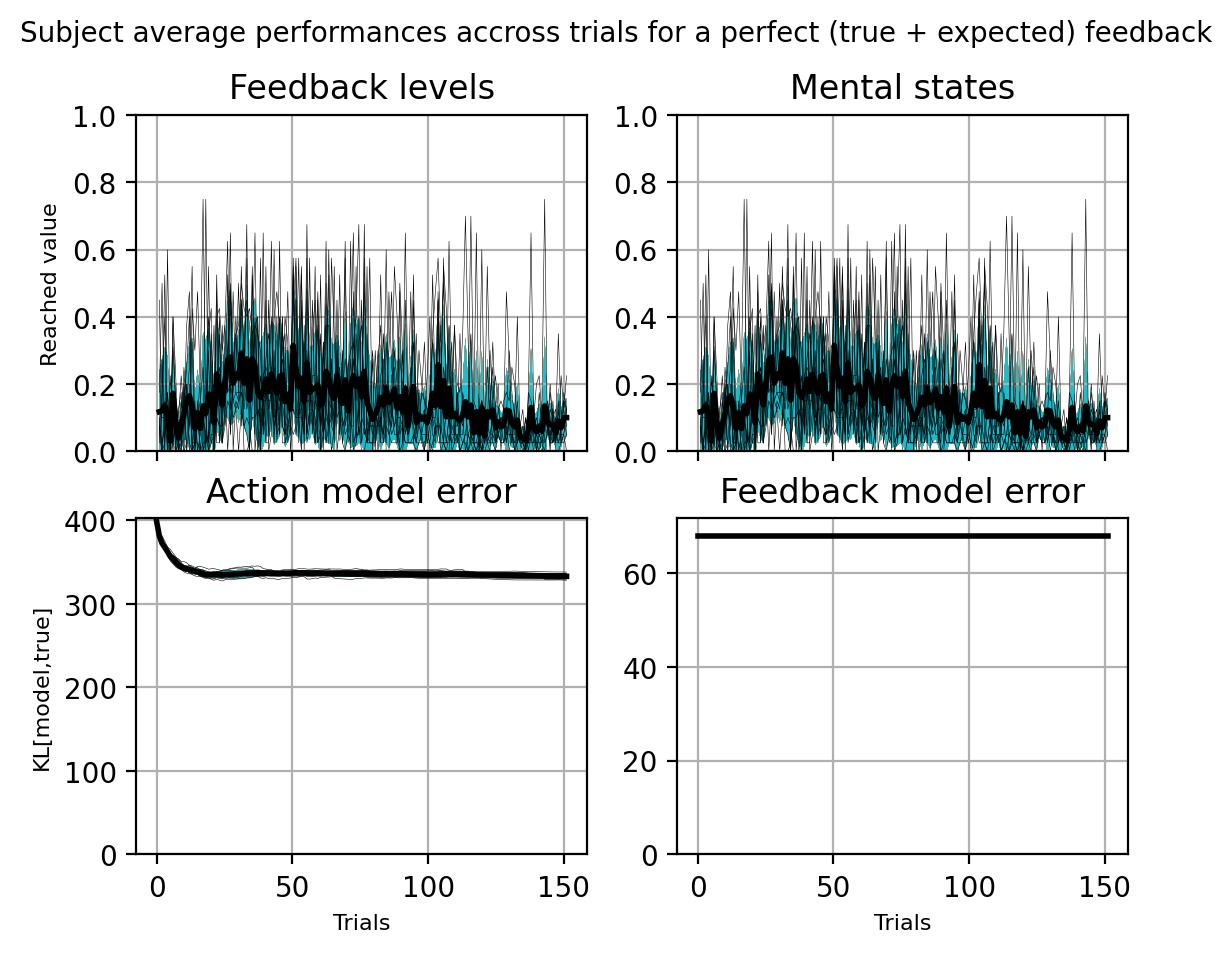

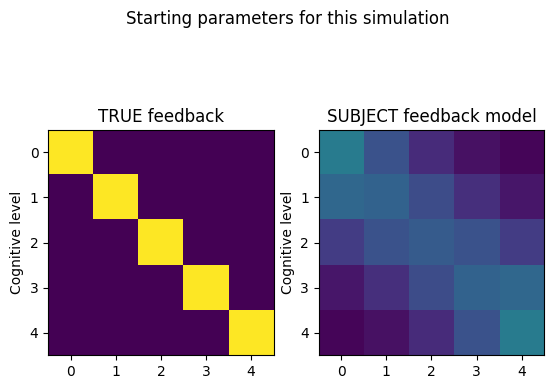

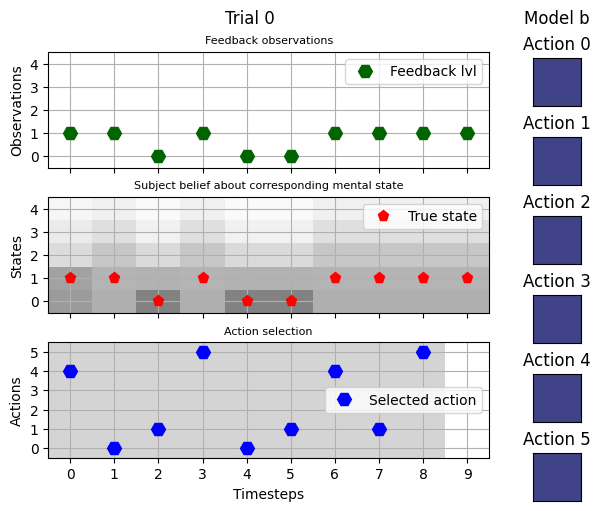

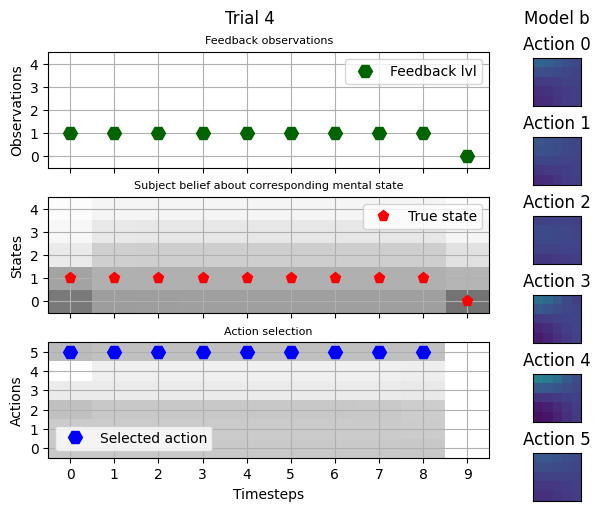

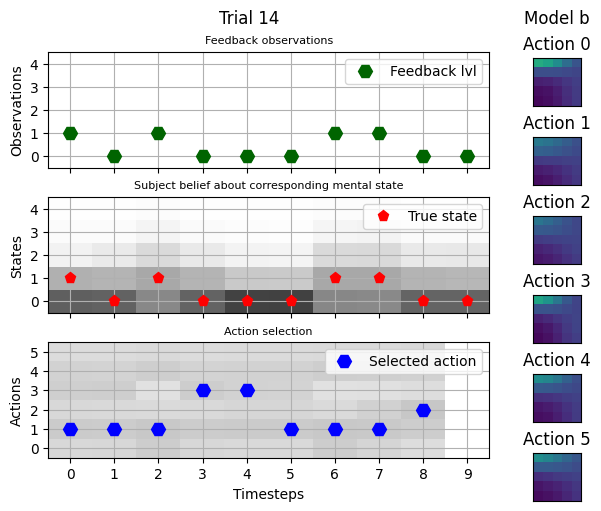

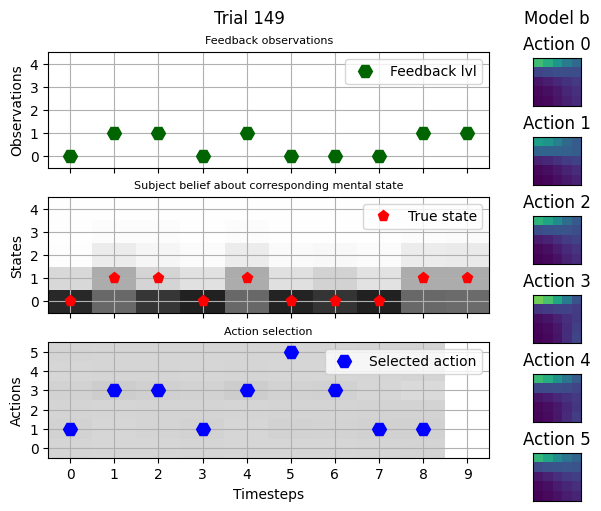

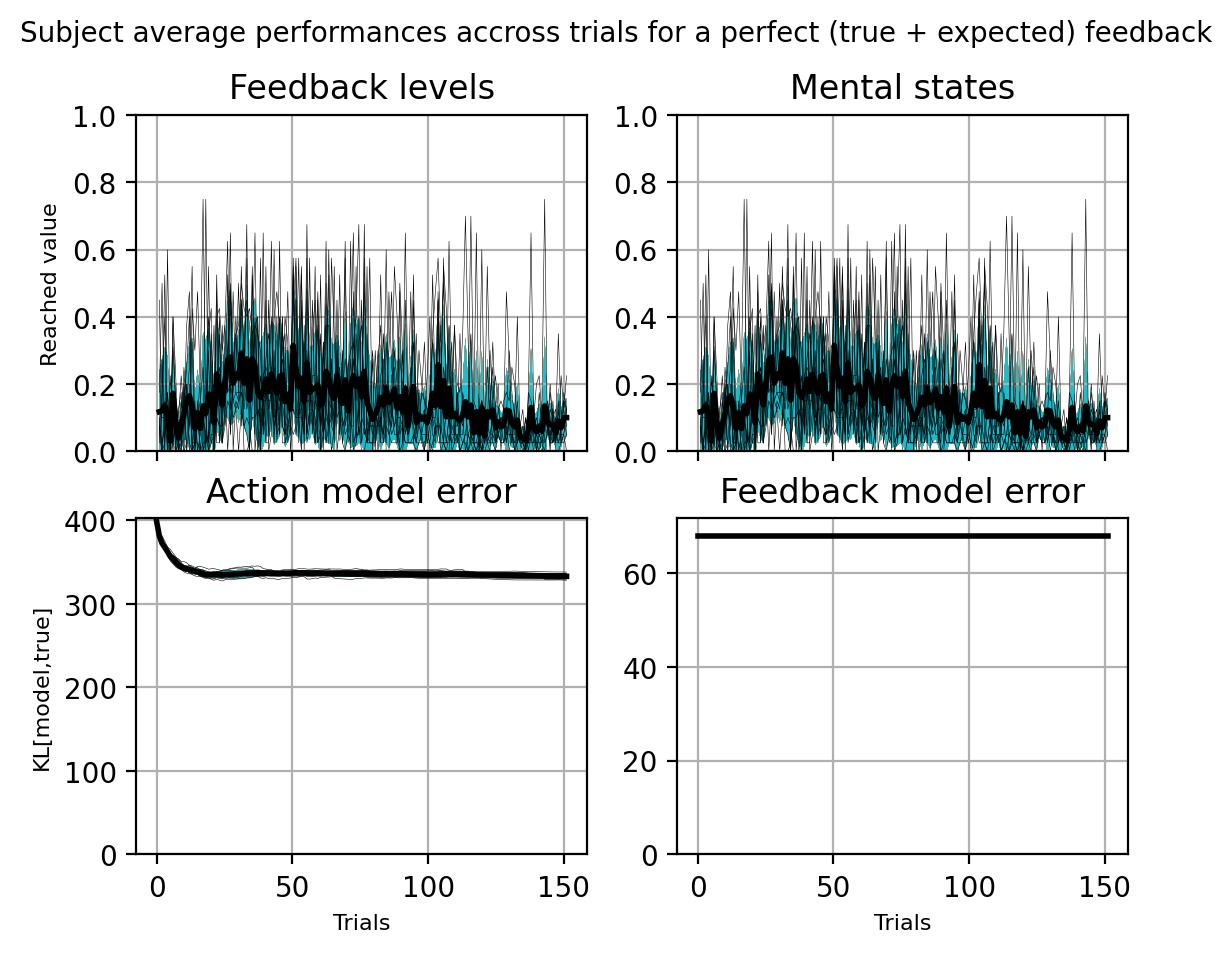

In [11]:
savepath = os.path.join(SAVING_FOLDER,"simulation2")

sigma_process = 0.01
sigma_model = 1.5

N_subj = 10
N_trials = 150

run_and_save_model(savepath,sigma_process,sigma_model,N_subj,N_trials)
_stm,_weight,_Nsubj,_Ntrials = extract_training_data(savepath)

subject = 4 # What subject are we studying ?
plot_these_trials = [0,4,14,149]
for trial in (plot_these_trials):
    plot_one_trial(_stm,_weight,subject,trial,"Trial " + str(trial),
                   save_fig_path=os.path.join(FIGURES_FOLDER,"sim2"),
                   name="trial_"+str(trial)+".png")   
plot_training_curve(_stm,_weight,"Subject average performances accross trials for a perfect (true + expected) feedback",
                save_fig_path=os.path.join(FIGURES_FOLDER,"sim2"),
                name="training_curve.png")

In these simulations, the subjects had such low expectations about the feedback signal that they mostly disregared its indications. It le to them not being able to build an adequate model of their mental actions (the matrix $\mathbf{b}$ in the trial plot is initially very noisy and approximative, and eventually diverges completely from the true transition rule). 

This simulation shows that subjects too doubtful of the feedback quality will not be able to learn, even if the latter was perfectly designed. In our simulations, this was due to the high amount of uncertainty in subject state inferences, in effect preventing precise transition learning. A "softer" transition rule (no cognitive pull, ability to generalize between starting states ike in **M2**) might have led to different results by making easier to learn good transitions.

## 3. Analyzing feedback noise and subject confidence joint effect on training outcome 

As the previous simulations have demonstrated, BCI training may fail :
- When the biomarker is too noisy, even if the subject is very trustful
- When the subject is too doubtful of the feedback, even if the feedback is very good

The next simulation maps intermediate cases in which the subject has variable degrees of trust in the feedback, whereas the chosen biomarker has variable degrees of quality. To do that, we'll run the same simulations for $\sigma_{model}$ and $\sigma_{process}$ in a range of $[0,3.0]$. Due to the high computational cost for so many simulations, we ran the calculations on a separate cluster and only use the results here !

You can check the scripts needed to get the following plots on cluster_scripts/cluster_stairs_005.py ! 
We extract the associated simulation outputs (state, perception & transition models errors) using cluster_scripts/cluster_stairs_005.py

C:\Users\annic\AppData\Local\Temp\ipykernel_34428\3173341035.py:22: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  orig_map=plt.cm.get_cmap('viridis')


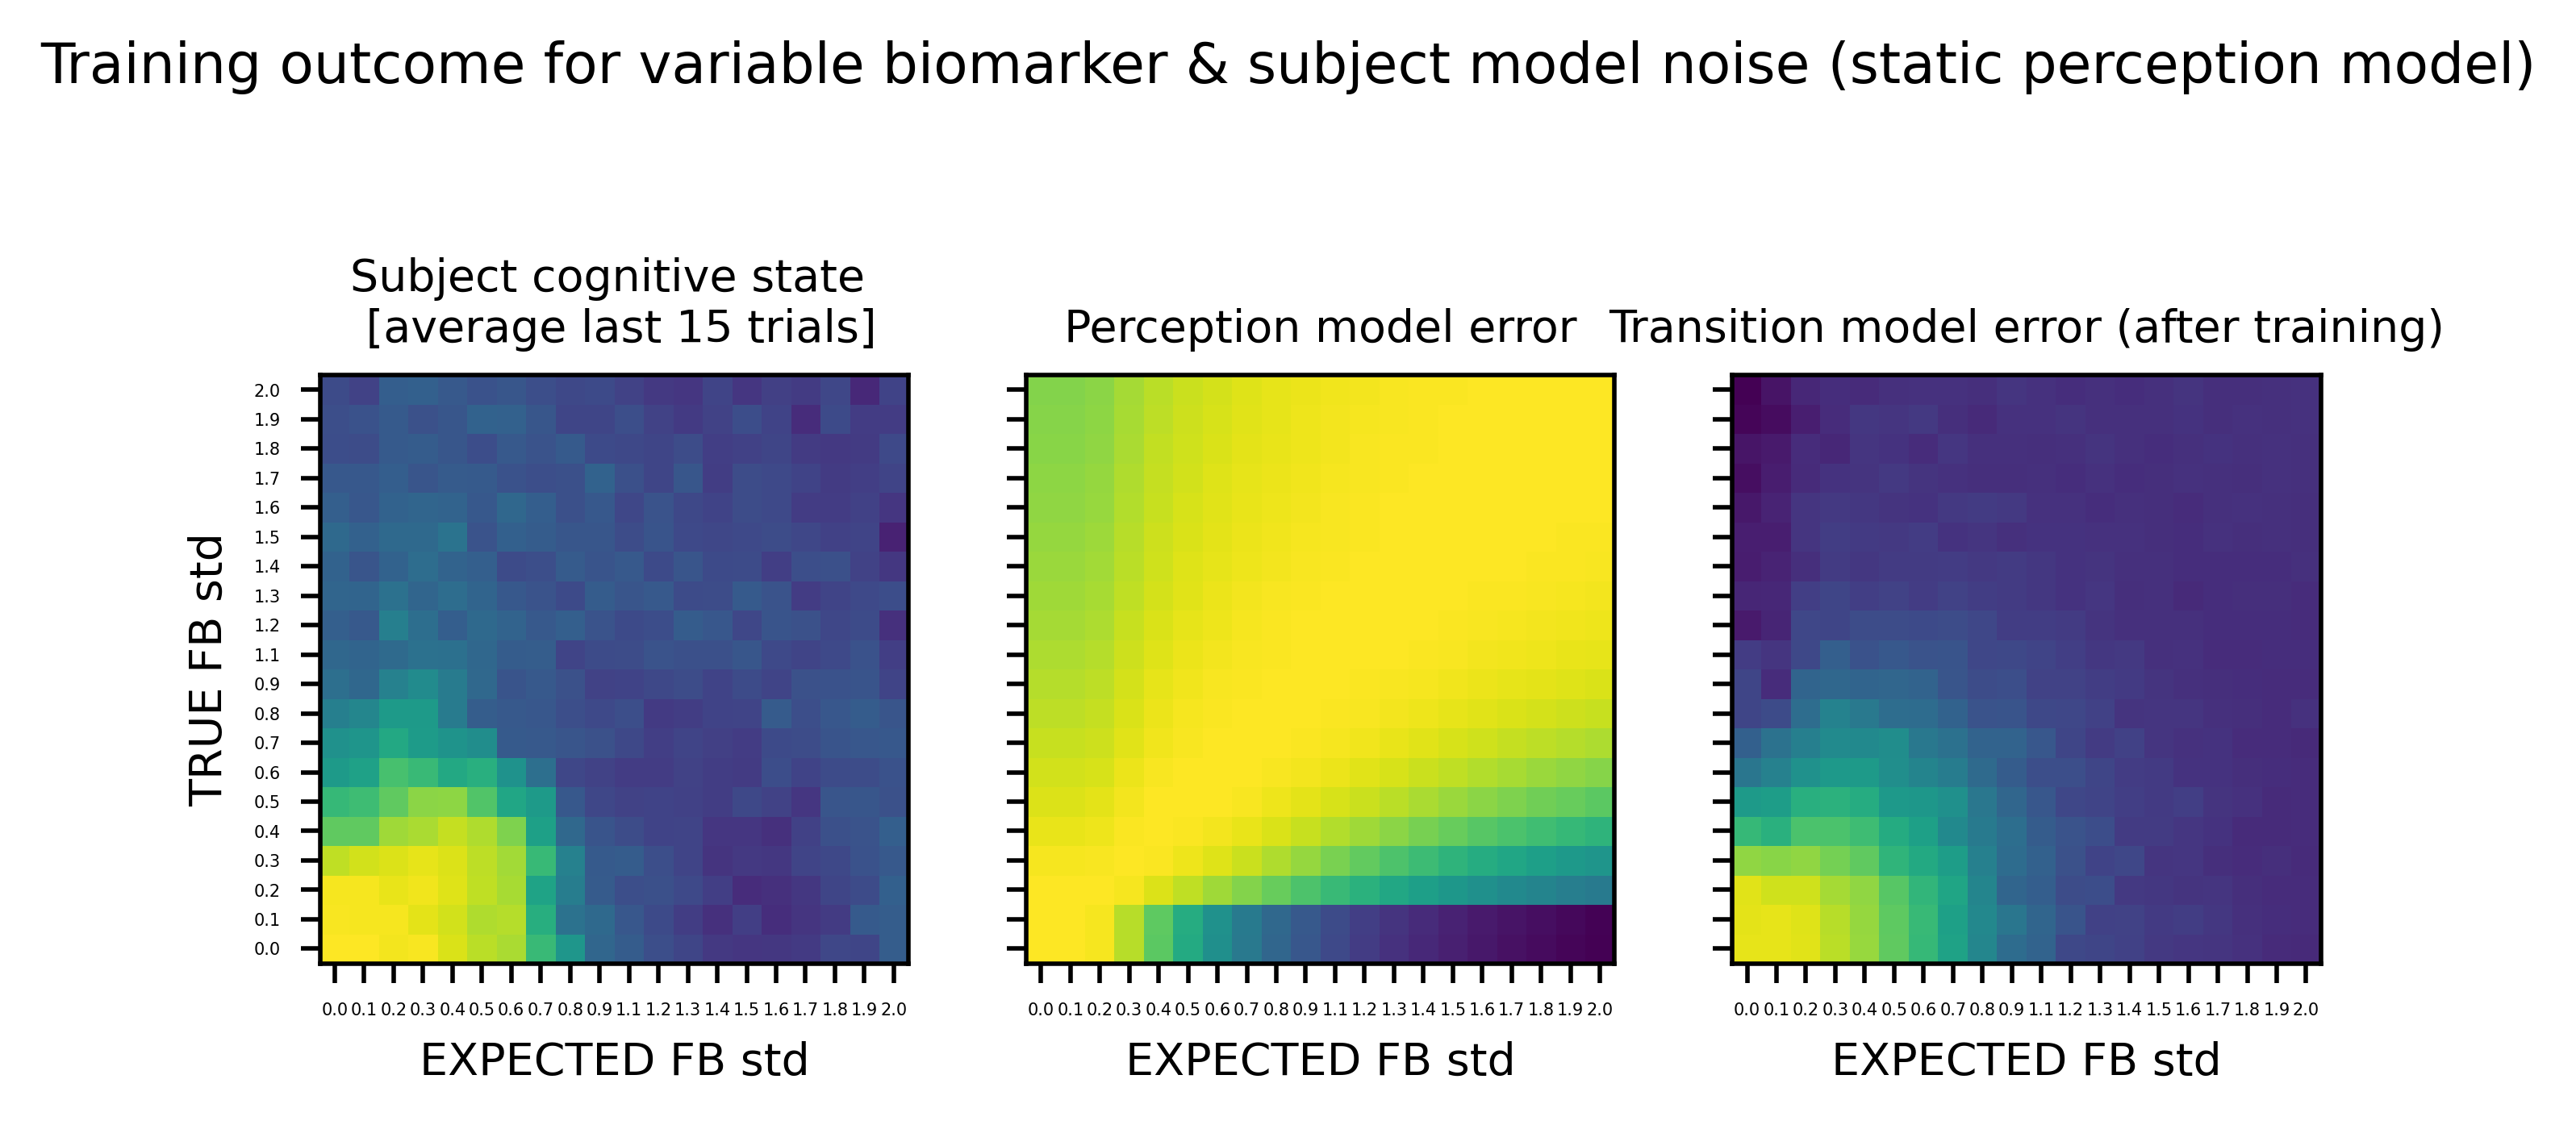

In [12]:
last_K_trials = 15

simulation_parameters_path = os.path.join(SAVING_FOLDER,"simulation3","KEYS")
with open(simulation_parameters_path, 'rb') as handle:
    simulation_parameters = pickle.load(handle)

simulation_performances_path = os.path.join(SAVING_FOLDER,"simulation3","PERFS")
with open(simulation_performances_path, 'rb') as handle:
    simulation_performances = pickle.load(handle)

array_of_final_states = np.mean(simulation_performances['s'][:,:,:,-last_K_trials:,:],axis = (-1,-2,-3))

array_of_final_a = np.mean(simulation_performances['a'][:,:,:,-1],axis = (-1))

array_of_final_b = np.mean(simulation_performances['b'][:,:,:,-1],axis = (-1))
max_b = np.max(array_of_final_b)
min_b = np.min(array_of_final_b)



# getting the original colormap using cm.get_cmap() function 
orig_map=plt.cm.get_cmap('viridis') 
  
# reversing the original colormap using reversed() function 
reversed_map = orig_map.reversed() 

fig2,axes = plt.subplots(1,3,sharey=True,dpi=500)
fig2.suptitle("Training outcome for variable biomarker & subject model noise (static perception model)",fontsize = 10,y=0.82)
# fig2.tight_layout()
# fig2.subplots_adjust(top=0.95)

axes[0].imshow(array_of_final_states,vmin=0,interpolation='nearest')
axes[0].set_title("Subject cognitive state \n [average last 15 trials]",fontsize = 8)
axes[0].set_ylabel("TRUE FB std",fontsize = 8)
axes[0].set_xlabel("EXPECTED FB std",fontsize = 8)

axes[1].imshow(array_of_final_a,vmin=0,interpolation='nearest',cmap = reversed_map)
axes[1].set_title("Perception model error",fontsize = 8)
axes[1].set_xlabel("EXPECTED FB std",fontsize = 8)

axes[2].imshow(array_of_final_b,interpolation='nearest',cmap = reversed_map,
                             vmin=0,vmax=max_b)
axes[2].set_title("Transition model error (after training)",fontsize = 8)
axes[2].set_xlabel("EXPECTED FB std",fontsize = 8)

x_axis = simulation_parameters[:,0,0]
y_axis = simulation_parameters[0,:,1]
for ax in axes :
    ax.invert_yaxis()
    ax.set_yticks(range(x_axis.shape[0]))
    ax.set_yticklabels(np.round(x_axis,1),fontsize = 3)

    ax.set_xticks(range(y_axis.shape[0]))
    ax.set_xticklabels(np.round(y_axis,1),fontsize = 3)

The last plot shows the range of optimal parameters leading to successful biomarker regulation (A) and good model learning (C). Plot B shows the perception model error of the subject in this particular case.

As expected, a high biomarker reliability is necessary for successful training, but it is not sufficient : high amounts of subject distrust (or ignorance) of the feedback mapping leads to poor performances even if the feedback shown is of high quality. 

One can also notice that for quite noisy feedbacks like $\sigma_{process} \sim 0.6$, (akin to noisy biomarker or sensors), subjects with lower quality expectations ($\sigma_{model} \sim 0.5$) perform much better than those expecting the feedback to perfeclty reflect their mental states. 

Similarly, when the subjects doubt about the feedback too much  ($\sigma_{model} \sim 1.0$), a somewhat more noisy feedback $\sigma_{process} \sim 0.6$ seems to lead to slightly better regulation performances.

### What are the optimal subject priors depending on the quality of the biomarker ?

Depending on the quality of the feedback provided, the training outcome may benefit from different subject initial beliefs. Those are parameters that the experimenter may affect (by providing instructions, etc.) For various biomarker qualities, we plot the training outcomes for our subjects : 

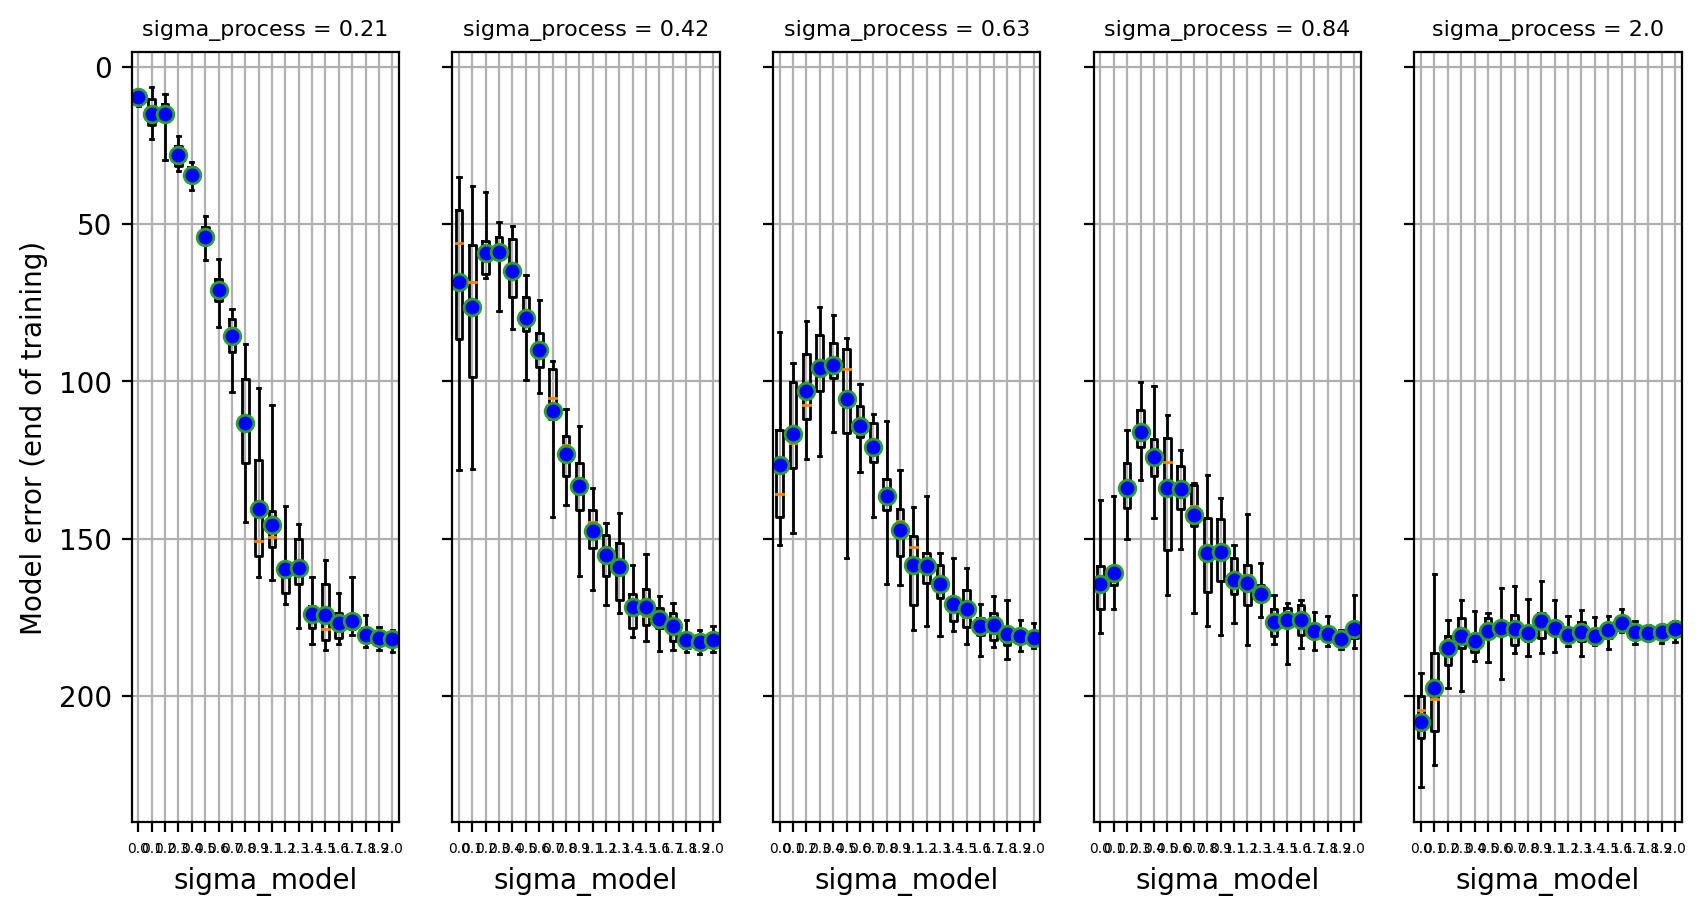

In [13]:
fixed_feedback_quality_indexes = [2,4,6,8,19]

fig2,axs = plt.subplots(1,len(fixed_feedback_quality_indexes),figsize=(10,5),dpi=200,sharey=True)
if (type(axs)!=np.ndarray):
    axs = np.array([axs])

axs[0].set_ylabel("Model error (end of training)")
for k,ax in enumerate(axs):
    index = fixed_feedback_quality_indexes[k]
    b_model_for_this_true_fb = simulation_performances['b'][index,:,:,-1]
    
    true_fb_std = simulation_parameters[index,0,0]
    feedback_belief_stds = simulation_parameters[index,:,1]

    ax.set_title("sigma_process = " + str(np.round(true_fb_std,2)),fontsize=8)
    ax.boxplot([b_model_for_this_true_fb[k,:] for k in range(b_model_for_this_true_fb.shape[0])], 
               showmeans=True, whis = 99,
                meanprops={'marker':'o','markerfacecolor':'blue'})
    ax.set_xticklabels(np.round(feedback_belief_stds,1),fontsize=5)
    ax.set_xlabel("sigma_model")
    ax.grid()
    # for k in range(b_model_for_this_true_fb.shape[0]) : #iterate over feedback belief values
    #     feedback_belief_std = simulation_parameters[fixed_feedback_quality_index,k,1]
    #     ax.boxplot(b_model_for_this_true_fb[k,:], showmeans=True, whis = 99)
ax.invert_yaxis()

It seems that to get optimal regulation in the largest number of cases, we needed our subjects to be quite confident in the feedback informational quality. However, subjects should know it is noisy ($\sigma_{model} \sim 0.4$). This parameter allows subjects to adapt effectively to the widest range of (true) biomarker noise.

We can also plot the cognitive states achieved by subjects at the end of the simulation for each of those initial parameters. Note the (non-linear) relationship between final mental state and mental action model quality at the end of the training.

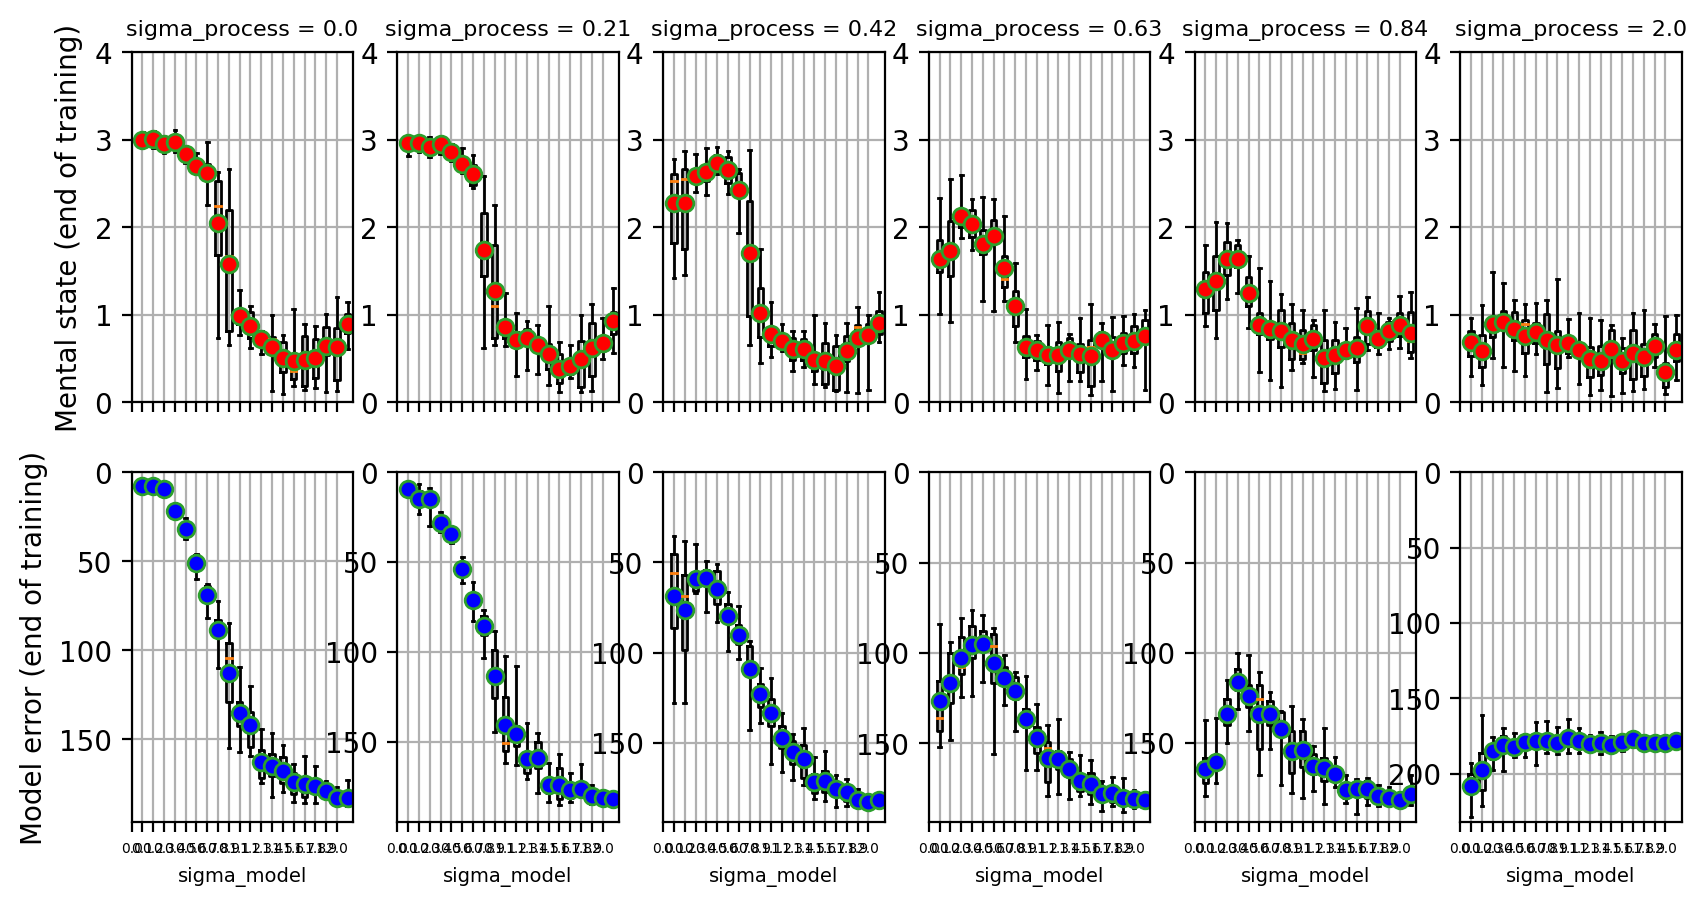

In [14]:
fixed_feedback_quality_indexes = [0,2,4,6,8,19]
last_K_trials = 15

fig3,axs = plt.subplots(2,len(fixed_feedback_quality_indexes),figsize=(10,5),dpi=200,sharex=True)
if (type(axs)!=np.ndarray):
    axs = np.array([axs])

axs[0,0].set_ylabel("Mental state (end of training)")
axs[1,0].set_ylabel("Model error (end of training)")
for k,ax in enumerate(axs[0,:]):
    index = fixed_feedback_quality_indexes[k]
    final_s = np.mean(simulation_performances['s'][index,:,:,-last_K_trials:,:],axis=(-1,-2))
    
    true_fb_std = simulation_parameters[index,0,0]
    feedback_belief_stds = simulation_parameters[index,:,1]

    ax.boxplot([final_s[k,:] for k in range(final_s.shape[0])], 
               showmeans=True, whis = 99,
                meanprops={'marker':'o','markerfacecolor':'red'})
    ax.grid()
    ax.set_ylim([0.0,4.0])
    # for k in range(b_model_for_this_true_fb.shape[0]) : #iterate over feedback belief values
    #     feedback_belief_std = simulation_parameters[fixed_feedback_quality_index,k,1]
    #     ax.boxplot(b_model_for_this_true_fb[k,:], showmeans=True, whis = 99)
    # ax.invert_yaxis()
    ax.set_title("sigma_process = " + str(np.round(true_fb_std,2)),fontsize=8)
for k,ax in enumerate(axs[1,:]):
    index = fixed_feedback_quality_indexes[k]
    b_model_for_this_true_fb = simulation_performances['b'][index,:,:,-1]
    
    true_fb_std = simulation_parameters[index,0,0]
    feedback_belief_stds = simulation_parameters[index,:,1]

   
    ax.boxplot([b_model_for_this_true_fb[k,:] for k in range(b_model_for_this_true_fb.shape[0])], 
               showmeans=True, whis = 99,
                meanprops={'marker':'o','markerfacecolor':'blue'})
    ax.set_xticks(range(feedback_belief_stds.shape[0]))
    ax.set_xticklabels(np.round(feedback_belief_stds,1),fontsize=5)
    ax.set_xlabel("sigma_model",fontsize= 7)
    ax.grid()   
    ax.set_ylim(bottom=0,top = np.max( simulation_performances['b'][:,:,:,-1]))
    ax.invert_yaxis()